# The New York Social Graph


[New York Social Diary](https://www.newyorksocialdiary.com/) provides a
fascinating lens onto New York's socially well-to-do.  The data forms a natural social graph for New York's social elite.  Take a look at this page of a recent [To Love Unconditionally](https://www.newyorksocialdiary.com/to-love-unconditionally/).

You will notice the photos have carefully annotated captions labeling those that appear in the photos.  We can think of this as implicitly implying a social graph: there is a connection between two individuals if they appear in a picture together.

For this project, we will assemble the social graph from photo captions for parties.  Using this graph, we can make guesses at the most popular socialites, the most influential people, and the most tightly coupled pairs.

We will attack the project in three phases:
1. Get a list of all the photo pages to be analyzed.
2. Get all captions in each party, Parse all of the captions and extract guests' names.
3. Assemble the graph, analyze the graph and answer the questions

## Phase One


The first step is to crawl the data.  We want photos from parties on or before December 1st, 2014.  Go to the [Party Pictures Archive](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures) to see a list of (party) pages.  We want to get the url for each party page, along with its date.

Here are some packages that you may find useful.  You are welcome to use others, if you prefer.

In [1]:
import requests
#!pip install dill
import dill
import glob
from bs4 import BeautifulSoup
from datetime import datetime
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

import itertools  # itertools.combinations may be useful
import networkx as nx

#!pip install spacy
#!python -m spacy download en_core_web_lg

import spacy
from spacy.language import Language
from spacy.tokens import Span

We recommend using Python [Requests](http://docs.python-requests.org/en/master/) to download the HTML pages, and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) to process the HTML.  Let's start by getting the [first page](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures).

In [2]:
nysd_url = "https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures"
page = requests.get(nysd_url) # Use requests.get to download the page.

Now, we process the text of the page with BeautifulSoup.

In [3]:
soup = BeautifulSoup(page.text, "lxml")

This page has links to 50 party pages. Look at the structure of the page and determine how to isolate those links.  Your browser's developer tools (usually `Cmd`-`Option`-`I` on Mac, `Ctrl`-`Shift`-`I` on others) offer helpful tools to explore the structure of the HTML page.

Once you have found a pattern, use BeautifulSoup's [select](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#css-selectors) or [find_all](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#find) methods to get those elements.

In [4]:
links = soup.select("div.views-row")

print("URL: ", links[0].find("a").get("href"))
print("Date: ", links[0].select("span.field-content")[1].text)

URL:  /web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/kicks-offs-sing-offs-and-pro-ams
Date:  Friday, September 11, 2015


There should be 50 per page.

In [5]:
len(links) == 50

True

Let's take a look at that first link.  Figure out how to extract the URL of the link, as well as the date.  You probably want to use `datetime.strptime`.  See the [format codes for dates](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) for reference.

In [6]:
"/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/grand-finale-of-the-hampton-classic-horse-show">Grand Finale of the Hampton Classic Horse Show</a>

SyntaxError: invalid syntax (3998999942.py, line 1)

In [7]:
link = links[0]
# Check that the title and date match what you see visually.
links[0].find("a").get("href")

'/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/kicks-offs-sing-offs-and-pro-ams'

For purposes of code reuse, let's put that logic into a function.  It should take the link element and return the URL and date parsed from it.

In [8]:
def get_link_date(el):
    url = el.find("a").get("href")
    date_text = el.select("span.field-content")[1].text
    ## Example date format:
    ## Tuesday, September 1, 2015
    date = datetime.strptime(date_text, "%A, %B %d, %Y")
    return url, date

get_link_date(links[0])

('/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/kicks-offs-sing-offs-and-pro-ams',
 datetime.datetime(2015, 9, 11, 0, 0))

You may want to check that it works as you expected.

Once that's working, let's write another function to parse all of the links on a page.  Thinking ahead, we can make it take a Requests [Response](https://requests.readthedocs.io/en/master/api/#requests.Response) object and do the BeautifulSoup parsing within it.

In [9]:
def get_links(response):
  links = []
  for r in response:
    links.append(get_link_date(r))
  return links # A list of URL, date pair s

get_links(links)

[('/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/kicks-offs-sing-offs-and-pro-ams',
  datetime.datetime(2015, 9, 11, 0, 0)),
 ('/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/grand-finale-of-the-hampton-classic-horse-show',
  datetime.datetime(2015, 9, 1, 0, 0)),
 ('/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/riders-spectators-horses-and-more',
  datetime.datetime(2015, 8, 26, 0, 0)),
 ('/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/artist-and-writers-and-designers',
  datetime.datetime(2015, 8, 20, 0, 0)),
 ('/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/garden-parties-kickoffs-and-summer-benefits',
  datetime.datetime(2015, 8, 17, 0, 0)),
 ('/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/the-summer-set',
  datetime.datetime(2015, 8, 12, 0, 0)),
 ('/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/201

If we run this on the previous response, we should get 50 pairs.

In [10]:
# These should be the same links from earlier
len(get_links(links)) == 50

True

But we only want parties with dates on or before the first of December, 2014.  Let's write a function to filter our list of dates to those at or before a cutoff.  Using a keyword argument, we can put in a default cutoff, but allow us to test with others.

In [11]:
def filter_by_date(links, cutoff=datetime(2014, 12, 1)):
    # Return only the elements with date <= cutoff
    return [link for link in links if link[1] <= cutoff]

filter_by_date(get_links(links))

[]

With the default cutoff, there should be no valid parties on the first page.  Adjust the cutoff date to check that it is actually working.

In [12]:
# Double check the dates are being extracted correctly
len(filter_by_date(get_links(links))) == 0

True

Now we should be ready to get all of the party URLs.  Click through a few of the index pages to determine how the URL changes.  Figure out a strategy to visit all of them.

HTTP requests are generally IO-bound.  This means that most of the time is spent waiting for the remote server to respond.  If you use `requests` directly, you can only wait on one response at a time.  [requests-futures](https://github.com/ross/requests-futures) lets you wait for multiple requests at a time.  You may wish to use this to speed up the downloading process.

In [ ]:
#!pip install requests-futures
#from requests_futures.sessions import FuturesSession

link_list = []
# You can use link_list.extend(others) to add the elements of others
# to link_list.

for i in range(1, 27):
  index_url = f"https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures?page={i}"
  page = requests.get(index_url)
  soup = BeautifulSoup(page.text, "lxml")
  links = soup.select("div.views-row")
  link_list.extend(filter_by_date(get_links(links)))
  time.sleep(10) ### Avoid getting blocked by making requests too quickly

In the end, you should have 1193 parties.

In [ ]:
# Make sure you are using the same /web/stringofdigits/... for each page
# This is to prevent the archive from accessing later copies of the same page
# If you are off by a just a few, that can be the archive misbehaving
len(link_list) == 1193

In case we need to restart the notebook, we should save this information to a file.  There are many ways you could do this; here's one using `dill`.

In [ ]:
dill.dump(link_list, open('nysd-links.pkd', 'wb'))

To restore the list, we can just load it from the file.  When the notebook is restarted, you can skip the code above and just run this command.

In [6]:
link_list = dill.load(open('nysd-links.pkd', 'rb'))
link_list = dill.load(open('nysd-links.pkd', 'rb'))

print(len(link_list))
print(link_list[0])
print(link_list[-1])

1213
('/web/20150918040703/http://www.newyorksocialdiary.com/party-pictures/2014/the-thanksgiving-day-parade-from-the-ground-up', datetime.datetime(2014, 12, 1, 0, 0))
('/web/20160414071258/http://www.newyorksocialdiary.com/party-pictures/2007/orchids-growing-wild', datetime.datetime(2007, 2, 21, 0, 0))


### Question 1: In which month did most of the parties occur? (10 p)
### Question 2: What is the overall trend of parties from 2007 to 2014? (10 p)
Use visualizations to answer the two questions above. Ensure that you interpret your plots thoroughly.

month
1      60
2      76
3     133
4     110
5     124
6     111
7     110
8      93
9      99
10    111
11    111
12     75
dtype: int64


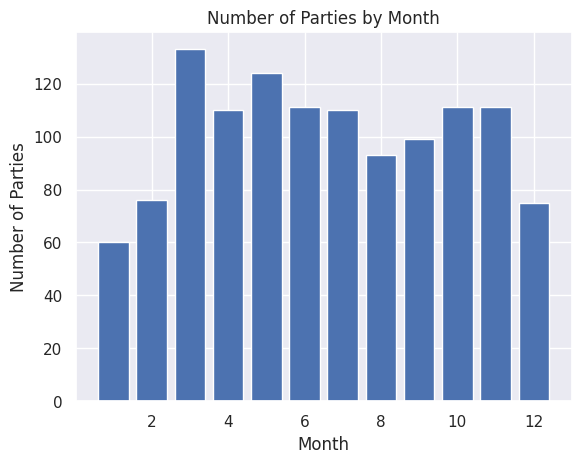

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame(link_list, columns=['url', 'date'])
df['month'] = df['date'].dt.month

# Group by month and count the number of parties in each month
monthly_counts = df.groupby('month').size()

print(monthly_counts)

plt.bar(monthly_counts.index, monthly_counts.values)
plt.xlabel("Month")
plt.ylabel("Number of Parties")
plt.title("Number of Parties by Month")

plt.show()

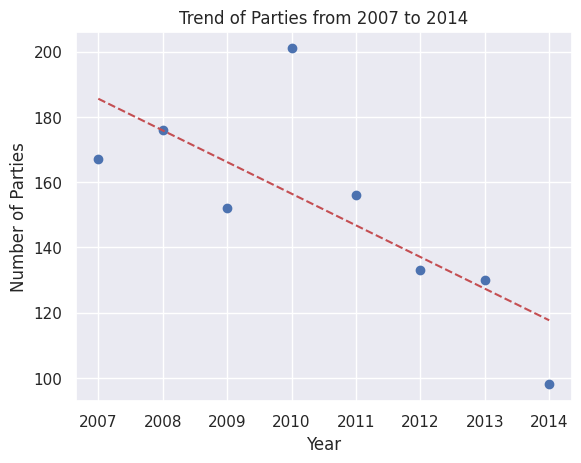

In [ ]:
df['year'] = df['date'].dt.year

## Number of parties per year
yearly_counts = df.groupby('year').size()

plt.scatter(yearly_counts.index, yearly_counts.values)
z = np.polyfit(yearly_counts.index, yearly_counts.values, 1)
p = np.poly1d(z)
plt.plot(yearly_counts.index, p(yearly_counts.index), "r--")

plt.xlabel("Year")
plt.ylabel("Number of Parties")
plt.title("Trend of Parties from 2007 to 2014")

plt.show()


## Phase Two


In this phase, we concentrate on getting the names out of captions for a given page.  We'll start with [the benefit cocktails and dinner](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/celebrating-the-neighborhood) for [Lenox Hill Neighborhood House](http://www.lenoxhill.org/), a neighborhood organization for the East Side.

Take a look at that page.  Note that some of the text on the page is captions, but others are descriptions of the event.  Determine how to select only the captions.

In [13]:
url = "https://web.archive.org/web/20151114014941/http://www.newyorksocialdiary.com/party-pictures/2015/celebrating-the-neighborhood"
page = requests.get(url)
soup = BeautifulSoup(page.text, "lxml")



In [14]:
captions = soup.select("div.photocaption")

By our count, there are about 110.  But if you're off by a couple, you're probably okay.

In [15]:
# These are for the specific party referenced in the text
abs(len(captions) - 110) < 5

True

Let's encapsulate this in a function.  As with the links pages, we want to avoid downloading a given page the next time we need to run the notebook.  While we could save the files by hand, as we did before, a checkpoint library like [ediblepickle](https://pypi.python.org/pypi/ediblepickle/1.1.3) can handle this for you.  (Note, though, that you may not want to enable this until you are sure that your function is working.)

You should also keep in mind that HTTP requests fail occasionally, for transient reasons.  You should plan how to detect and react to these failures.   The [retrying module](https://pypi.python.org/pypi/retrying) is one way to deal with this.

In [16]:
def get_captions(path):
  url = f"https://web.archive.org/{path}"
  page = requests.get(url)
  soup = BeautifulSoup(page.text, "lxml")
  return soup.select("div.photocaption")

This should get the same captions as before.

In [17]:
# This cell is expecting get_captions to return a list of the captions themselves
# Other routes to a solution might need to adjust this cell a bit
captions == get_captions("/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/celebrating-the-neighborhood")

True

Now that we have some sample captions, let's start parsing names out of those captions.  There are many ways of going about this, and we leave the details up to you.  Some issues to consider:

  1. Some captions are not useful: they contain long narrative texts that explain the event.  Try to find some heuristic rules to separate captions that are a list of names from those that are not.  A few heuristics include:
    - look for sentences (which have verbs) and as opposed to lists of nouns. For example, [`nltk` does part of speech tagging](http://www.nltk.org/book/ch05.html) but it is a little slow. There may also be heuristics that accomplish the same thing.
    - Similarly, spaCy's [entity recognition](https://spacy.io/docs/usage/entity-recognition) could be useful here.
    - Look for commonly repeated threads (e.g. you might end up picking up the photo credits or people such as "a friend").
    - Long captions are often not lists of people.  The cutoff is subjective, but for grading purposes, *set that cutoff at 250 characters*.
  2. You will want to separate the captions based on various forms of punctuation.  Try using `re.split`, which is more sophisticated than `string.split`. **Note**: Use regex exclusively for name parsing.
  3. This site is pretty formal and likes to say things like "Mayor Michael Bloomberg" after his election but "Michael Bloomberg" before his election.  Can you find other titles that are being used?  They should probably be filtered out because they ultimately refer to the same person: "Michael Bloomberg."
  4. There is a special case you might find where couples are written as eg. "John and Mary Smith". You will need to write some extra logic to make sure this properly parses to two names: "John Smith" and "Mary Smith".
  5. When parsing names from captions, it can help to look at your output frequently and address the problems that you see coming up, iterating until you have a list that looks reasonable. Because we can only asymptotically approach perfect identification and entity matching, we have to stop somewhere.
  
**Questions worth considering:**
  1. Who is Patrick McMullan and should he be included in the results? How would you address this?
  2. What else could you do to improve the quality of the graph's information?

In [18]:
### Configure spaCy to use expanded person entities
### To process titles (Mr., Mrs., Dr., etc.)
### See https://spacy.io/usage/rule-based-matching#models-rules
@Language.component("expand_person_entities")
def expand_person_entities(doc):
    new_ents = []
    for ent in doc.ents:
        if ent.label_ == "PERSON" and ent.start != 0:
            prev_token = doc[ent.start - 1]
            if prev_token.text in ("Dr", "Dr.", "Mr", "Mr.", "Mrs", "Mrs.", "Ms", "Ms."):
                new_ent = Span(doc, ent.start - 1, ent.end, label=ent.label)
                new_ents.append(new_ent)
            else:
                new_ents.append(ent)
        else:
            new_ents.append(ent)
    doc.ents = new_ents
    return doc

nlp = spacy.load("en_core_web_lg")
##nlp.add_pipe("expand_person_entities", after="ner")

In [19]:
test = "John and Jane Smith"
test2 = "Jean Shafiroff and Mary Mahoney"
def split_married_couple(text):
    groups = re.split(r',\s*(and|with|&)\s*', text)
    names = []
    for group in groups:
        match = re.search(r'(.*) (?:and|&) (.*) (\w+)', group)
        if match and len(match.group(1).split()) == 1:  ### Only repair names if first name in pair is just first name
            first_name1 = match.group(1)
            first_name2 = match.group(2)
            last_name = match.group(3)
            names.extend([f"{first_name1} {last_name}", f"{first_name2} {last_name}"])
        else:
            names.append(group)
    return ", ".join(names)

In [210]:
def remove_blacklisted_words(text):
    ### Pre-processing cleaning.  Remove blacklisted words that pass through spaCy filter
    text = re.sub(r"Frick Director", "", text)
    text = re.sub(r"Chair(wo)?m(e|a)n", "", text)
    text = re.sub(r"CFO", "", text)
    text = re.sub(r"Honoree", "", text)
    text = re.sub(r"Dr\.*", "", text)
    text = re.sub(r"Jr\.*", "", text)
    text = re.sub(r"Esq\.*", "", text)
    text = re.sub(r"M\.*D\.*", "", text)
    text = re.sub(r"PhD\.*", "", text)
    text = re.sub(r"PsyD\.*", "", text)
    text = re.sub(r"Benefit\s+", "", text)
    text = re.sub(r"Composer\s+", "", text)
    text = re.sub(r"Chair\s+", "", text)
    text = re.sub(r"Father\s+", "", text)
    text = re.sub(r"Executive Director\s+", "", text)

    return text

In [211]:
def pre_clean_name(name):
    name = str(name)
    name = re.sub(r"'s$", "", name)    ### remove trailing 's
    name = re.sub(r"\s+", " ", name)  ### replace sequences of multiple whitespaces with a single space char
    
    name = name.strip("/")
    name = name.strip("'")
    name = name.strip()
    
    return name

In [212]:
def post_clean_name(caption):
    new_caption = []
    for item in caption:
        if (item not in [",", "and", "with", '', ' '] and
            len(item.split()) < 4 and ### Things over 5 words are probably not names
            len(item.split()) > 1):   ### 1 word things are probably not identifiable names
            new_caption.append(item)

    return new_caption

In [213]:
def extract_names_re(caption):
    caption = remove_blacklisted_words(caption)
    caption = split_married_couple(caption)
    caption = pre_clean_name(caption)

    caption = re.split(r"\s*(,|and|with|&)+\s+", caption)

    caption = post_clean_name(caption)
    
    return caption

In [214]:
[extract_names_re(caption.text) for caption in captions]

[[],
 [],
 ['Gretchen Dow Simpson', 'James Baird', 'Tina Howe'],
 ['Genevieve Mathis', 'Ed Sherin', 'Tony Sherin'],
 ['Robert MacNeil'],
 ['Joel Sanders', 'Paul Gunther', 'Pamela Joyner', 'Rick Stone'],
 ['Ed Sherin', 'Jane Alexander', 'Jace Alexander', 'Maddie Corman'],
 ['Steve Reich', 'Beryl Korot'],
 ['Stewart Wallace', 'Writer Rick Moody'],
 ['MacDowell Robert MacNeil', 'Jane Alexander', 'James Earl Jones'],
 ['Cheryl Young', 'Nicky Dawidoff'],
 ['Anne Jackson', 'Eli Wallach'],
 ['Genevieve Mathis', 'Tony Sherin'],
 ['Jane Alexander', 'Thomas Putnam'],
 ['Writers Amitav Ghosh', 'Deborah Baker'],
 ['Eileen Wiseman', 'William Banks', 'Ann Cox Chambers', 'Stephanie Olmsted'],
 ['Lynn Waterston', 'Sam Waterston'],
 ['Jace Alexander', 'Maddie Corman'],
 ['playwright Tina Howe', 'Jane Alexander'],
 ['Paul LeClerc', 'Emerita Helen Tucker'],
 ['Artist Jane Dickson', 'Brandon Fradd'],
 ['Chairs Bob', 'Stephanie Olmsted'],
 ['Coddy Granum', 'James Earl Jones'],
 ['Helen Tucker', 'Lewis Cull

In [22]:
def extract_names_spacy(caption):
    """
    Extracts names from a caption using spaCy.
    
    Args:
    caption: The caption text.
    
    Returns:
    A list of names extracted from the caption.
    """
    caption = split_married_couple(caption)
    caption = remove_blacklisted_words(caption)
    doc = nlp(split_married_couple(caption))
    names = [clean_name(ent) for ent in doc.ents if ent.label_ == "PERSON"]

    return names

In [23]:
def extract_other_spacy(caption):
    """
    Extracts names from a caption using spaCy.
    
    Args:
    caption: The caption text.
    
    Returns:
    A list of names extracted from the caption.
    """
    caption = split_married_couple(caption)
    caption = remove_blacklisted_words(caption)
    doc = nlp(split_married_couple(caption))
    other = [ent for ent in doc.ents if ent.label_ != "PERSON"]

    return other

In [182]:
## Raw caption text
[caption.text for caption in captions]

["The dinner scene at 7 World Trade Center for The MacDowell Colony's  evening in honor of Jane Alexander.",
 'Master Puppeteer Basil Twist',
 ' Gretchen Dow Simpson, James Baird, and Tina Howe ',
 ' Genevieve Mathis, Ed Sherin, and Tony Sherin ',
 ' Robert MacNeil ',
 ' Joel Sanders, Paul Gunther, Honorary Chair Artist Martin Puryear, Pamela Joyner, and Rick Stone ',
 ' Ed Sherin, Jane Alexander, Jace Alexander, and Maddie Corman ',
 ' Steve Reich and Beryl Korot ',
 ' Composer Stewart Wallace and Writer Rick Moody ',
 ' MacDowell Chairman Robert MacNeil, Jane Alexander, and James Earl Jones ',
 ' Cheryl Young and Nicky Dawidoff ',
 ' Anne Jackson and Eli Wallach ',
 ' Genevieve Mathis and Tony Sherin ',
 ' Jane Alexander and Thomas Putnam ',
 ' Writers Amitav Ghosh and Deborah Baker ',
 ' Eileen Wiseman, William Banks, Ann Cox Chambers, and Benefit Chair Stephanie Olmsted ',
 ' Lynn  and Sam Waterston ',
 ' Jace Alexander and Maddie Corman ',
 ' Artist Gretchen Dow Simpson, playwrigh

In [68]:
[caption.text for caption in all_captions if "and" in caption.text]

[' Laura Durning  and Roger Waters',
 ' Walter and Judy Shipley with Lewis Bernard ',
 ' Laura Durning, Tom Freston, Katie Joel, and Harvey Weinstein ',
 ' Valerie and Jeffrey Peltier ',
 ' Tom and Dana Petty ',
 ' Michael and Diana Lomonaco ',
 ' Alan and Jill Rappaport ',
 ' Amy Poehler and Alec Baldwin ',
 ' Gala Chairs John and Jodie Eastman ',
 ' Lisa Falcone and Cindy Gallop during the auction ',
 'Amy Poehler, Jorma Taccone, Will Forte, Seth Meyers, and Jason Sudeikis',
 ' Philip and Lisa Falcone, Ellen V. Futter, and Gala Chairs Allison and Roberto Mignone',
 ' Tom Brokaw and auctioneer C. Hugh Hildesdley',
 ' Jann Wenner and Gala Chair Lorne Michaels ',
 ' Kenan Thompson, Fred Armisen, and Andy Samberg ',
 ' Jane and Brian Williams ',
 ' Steve and Roberta Denning ',
 ' Juliette Jassens, Moran and Drew Demann, and Mark Janssens ',
 ' Katie Joel with Tom and Kathy Freston ',
 ' Tracy Morgan and Noris Bentivegna ',
 " Conan and Liza O'Brien with Amy Poehler ",
 ' Cathie Black and

In [43]:
## Cleaned caption text
[clean_name(split_married_couple(remove_blacklisted_words(caption.text))) for caption in captions]

["The dinner scene at 7 World Trade Center for The MacDowell Colony's evening in honor of Jane Alexander.",
 'Master Puppeteer Basil Twist',
 'Gretchen Dow Simpson, James Baird, and, Tina Howe',
 'Genevieve Mathis, Ed Sherin, and, Tony Sherin',
 'Robert MacNeil',
 'Joel Sanders, Paul Gunther, Honorary Chair Artist Martin Puryear, Pamela Joyner, and, Rick Stone',
 'Ed Sherin, Jane Alexander, Jace Alexander, and, Maddie Corman',
 'Steve Reich and Beryl Korot',
 'Composer Stewart Wallace and Writer Rick Moody',
 'MacDowell Robert MacNeil, Jane Alexander, and, James Earl Jones',
 'Cheryl Young and Nicky Dawidoff',
 'Anne Jackson and Eli Wallach',
 'Genevieve Mathis and Tony Sherin',
 'Jane Alexander and Thomas Putnam',
 'Writers Amitav Ghosh and Deborah Baker',
 'Eileen Wiseman, William Banks, Ann Cox Chambers, and, Benefit Chair Stephanie Olmsted',
 'Lynn Waterston, Sam Waterston',
 'Jace Alexander and Maddie Corman',
 'Artist Gretchen Dow Simpson, playwright Tina Howe, and, Jane Alexande

Once you feel that your algorithm is working well on these captions, parse all of the captions and extract all the names mentioned.  

Now, run this sort of test on a few other pages.  You will probably find that other pages have a slightly different HTML structure, as well as new captions that trip up your caption parser.  But don't worry if the parser isn't perfect -- just try to get the easy cases.

Once you are satisfied that your caption scraper and parser are working, run this for all of the pages.  If you haven't implemented some caching of the captions, you probably want to do this first.

We use wget to scrape the NYSD archive, because the server kept rate limiting requests.  Scraping all parties in link_list takes about 20 minutes with this method.

In [28]:
#import subprocess
#subprocess.run(["wget", "-i", "links.txt", "--random-wait", "-P", "nysd"])

## Phase 3: Graph Analysis

For the remaining analysis, we think of the problem in terms of a
[network](http://en.wikipedia.org/wiki/Computer_network) or a
[graph](https://en.wikipedia.org/wiki/Graph_%28discrete_mathematics%29).  Any time a pair of people appear in a photo together, that is considered a link.  It is an example of  an **undirected weighted graph**. We recommend using python's [`networkx`](https://networkx.github.io/) library.

All in all, you should end up with over 100,000 captions and more than 110,000 names, connected in about 200,000 pairs.

In [59]:
def get_captions_file(webpage):
  soup = BeautifulSoup(webpage, "lxml")
  return soup.select("div.photocaption")

all_captions = []
for file in glob.glob("./nysd/*"):
    with open(file, "r", encoding='utf-8', errors='ignore') as f:
        webpage = f.read()
        captions = get_captions_file(webpage)
        all_captions.extend(captions)

In [60]:
print(len(all_captions))

71316


In [ ]:
#### spaCy solution

In [61]:
cleaned_captions = list(map(lambda caption: extract_names_spacy(caption.text), all_captions))

### Entities identified by spaCy that are not PERSON, for debugging purposes
other_labeled_words = [(ent, ent.label_) for ents in
                       map(lambda caption: extract_other_spacy(caption.text), all_captions)
                       for ent in ents]

len(cleaned_captions)

71316

In [62]:
unique_names = set([name for names in cleaned_captions for name in names])

len(unique_names)

72035

In [63]:
with open("names.txt", "w") as f:
    f.writelines([f"{str(name)}\n" for name in sorted(list(unique_names))])

In [64]:
with open("other.csv", "w") as f:
    f.write("Label, Text\n")
    f.writelines([f"{ent[1]},{ent[0]}\n" for ent in other_labeled_words])

In [65]:
list(unique_names)[:100]

['Christain Boccia',
 'Blake Seidel',
 'Gia Slowick',
 'Imelda Nicolas',
 'Patricia Marcellano',
 'Jill Helene',
 'Bobby Steinsdorfer',
 'Patti Roberts',
 'Don Laventhall',
 'Lydia Carlston',
 'Calvin Tomkins',
 'Susan Zises-Green',
 'Miranda Bass',
 'Meagan Bonan',
 'Anne Schultz',
 'Delfina Frers',
 'Barbara Duvowski',
 'Lynne Taylor-Corbet',
 'Serena Nikkah',
 'Gina Clarke',
 'Reshma Saujani',
 'Erica Figueroa',
 'Michael Tilson',
 'Mya',
 'Gail DeDona',
 'April Benasich',
 'Abiri',
 'Lindsey Pittas',
 'Jennifer Lim',
 'Jack Huston',
 'Irene R. Aitken',
 'Benasich',
 'Lexi Bennett',
 'Delphine Figueras',
 'Bob Garvy',
 'Ryan Stewart',
 'Hank Sandlass',
 'Carla Hill',
 'Ellen Grauer',
 'Jake Anderson',
 'Eri Stern',
 'Zak DeOssie',
 'Gilbert Kinney',
 'Beverly Leopold',
 'Mark Buller',
 'Paul Ferrillo',
 'Jacquie Garrett',
 'David Valger',
 'Daniel Meyer',
 'Elizabeth Hendrickson',
 'Amanda Seyfriend',
 'Michael Romano',
 'Cristobal Riestra',
 'David Redden',
 'Hayley Mogul',
 'Hanna

In [ ]:
#### Regex Solution

In [222]:
cleaned_captions_re = list(map(lambda caption: extract_names_re(caption.text), all_captions))

len(cleaned_captions_re)

unique_names_re = set([name for names in cleaned_captions_re for name in names])

len(unique_names_re)

with open("names_Re.txt", "w") as f:
    f.writelines([f"{str(name)}\n" for name in sorted(list(unique_names_re))])

## Question 3: Graph EDA (20 p)


- Use parsed names to create the undirected weighted network and visualize it (5 p)
- Report the number of nodes and edges (5 p)
- What is the diameter of this graph? (5 p)
- What is the average clustering coeff of the graph? How you interpret this number? (5 p)

In [217]:
G = nx.Graph()
for caption in cleaned_captions_re:
    pairs = itertools.combinations(caption, 2)
    for pair in pairs:
        first_person = pair[0]
        second_person = pair[1]
        if G.has_edge(first_person, second_person):
            G[first_person][second_person]['weight'] += 1
        else:
            G.add_edge(first_person, second_person, weight = 1)

degrees = sorted(G.degree(weight = "weight"), key = lambda x: (-x[1]))

In [218]:
print(degrees[:10])

[('Jean Shafiroff', 451), ('Mark Gilbertson', 358), ('Gillian Miniter', 350), ('Alexandra Lebenthal', 300), ('Geoffrey Bradfield', 257), ('Kamie Lightburn', 210), ('Somers Farkas', 207), ('Eleanora Kennedy', 203), ('Yaz Hernandez', 198), ('Andrew Saffir', 197)]


In [219]:
print(degrees[-10:])

[('Joana Steichen', 1), ('Irene Neves', 1), ('Pat Bass', 1), ('Fred Bass', 1), ('Mrs. Sogoloff', 1), ('Mr. Capriccio', 1), ('Wood Heller', 1), ('Stuart Match-Suna', 1), ('Rachel Klein,', 1), ('Molly Jong-Fast', 1)]


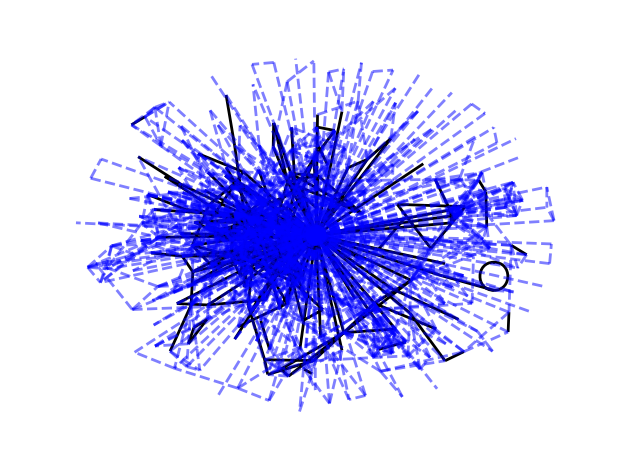

In [223]:
#### Draw subgraph for Jean Shafiroff (Highest Degree) to visualize an
#### example node with high importance.  Visualizing the entire graph
#### may be impossible to do in a meaningful way.

jean_shafiroff_subgraph = G.subgraph(nx.ego_graph(G, "Jean Shafiroff"))
deg = jean_shafiroff_subgraph.degree()
nlarge = G.subgraph([n for n in deg if deg[n[0]] >= 10])
nsmall = G.subgraph([n for n in deg if deg[n[0]] < 10])

elarge = [(u, v) for (u, v, d) in jean_shafiroff_subgraph.edges(data=True) if d["weight"] > 1]
esmall = [(u, v) for (u, v, d) in jean_shafiroff_subgraph.edges(data=True) if d["weight"] == 1]

pos = nx.spring_layout(jean_shafiroff_subgraph, seed=7)  # positions for all nodes - seed for reproducibility


# nodes
nx.draw_networkx_nodes(nlarge, pos, node_size=100)
nx.draw_networkx_nodes(nsmall, pos, node_size=25)

# edges
nx.draw_networkx_edges(jean_shafiroff_subgraph, pos, edgelist=elarge, width=2)
nx.draw_networkx_edges(
    jean_shafiroff_subgraph, pos, edgelist=esmall, width=2, alpha=0.5, edge_color="b", style="dashed"
)

# node labels
nx.draw_networkx_labels(nlarge, pos, font_size=8, font_family="sans-serif")
# edge weight labels
##edge_labels = nx.get_edge_attributes(jean_shafiroff_subgraph, "weight")
##nx.draw_networkx_edge_labels(jean_shafiroff_subgraph, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

## Question 4: Graph properties (20 p)

What real-world graph properties does this graph exhibit? Please show your work and interpret your answer. Does the result make sense given the nature of the graph?

## Question 4: Who are the most photogenic persons? (10 p)

The simplest question to ask is "who is the most popular"?  The easiest way to answer this question is to look at how many connections everyone has.  Return the top 100 people and their degree.  Remember that if an edge of the graph has weight 2, it counts for 2 in the degree.

**Checkpoint:** Some aggregate stats on the solution

    "count": 100.0
    "mean": 189.92
    "std": 87.8053034454
    "min": 124.0
    "25%": 138.0
    "50%": 157.0
    "75%": 195.0
    "max": 666.0

In [221]:
top_degrees_df = pd.DataFrame(degrees[:100])

top_degrees_df.describe()

,1
count,100.000000
mean,129.600000
std,60.143935
min,85.000000
25%,95.750000
50%,110.500000
75%,135.250000
max,451.000000


## Question 5: Centrality analysis (20 p)


Use eccentricity centrality, closeness centrality, betweenness centrality, prestige, and PageRank to identify the top 10 individuals with the highest centrality for each measure. How do you interpret the results?

Use 0.85 as the damping parameter for page rank, so that there is a 15% chance of jumping to another vertex at random.

**Checkpoint:** Some aggregate stats on the solution for pagerank

    "count": 100.0
    "mean": 0.0001841088
    "std": 0.0000758068
    "min": 0.0001238355
    "25%": 0.0001415028
    "50%": 0.0001616183
    "75%": 0.0001972663
    "max": 0.0006085816

## Question 6: best_friends (10 p)


Another interesting question is who tend to co-occur with each other.  Give us the 100 edges with the highest weights.

Google these people and see what their connection is.  Can we use this to detect instances of infidelity?

**Checkpoint:** Some aggregate stats on the solution

    "count": 100.0
    "mean": 25.84
    "std": 16.0395470855
    "min": 14.0
    "25%": 16.0
    "50%": 19.0
    "75%": 29.25
    "max": 109.0

In [ ]:
#temple form for the answer
best_friends = [(('Michael Kennedy', 'Eleanora Kennedy'), 41)] * 100
